# Chapter 2 — Sampling, Bias, and the Nature of Data

## 2.2 — Bootstrap and Confidence Intervals

Today, I’m continuing my exploration of sampling theory using the ANEEL complaint dataset. My focus is on understanding the sampling distribution of a statistic, the Central Limit Theorem (CLT), the standard error, and how bootstrapping helps in constructing confidence intervals—even when the population distribution is unknown.

## 2.2.1 Loading Real Data from ANEEL API

> ⚠️ Run the cell below locally to fetch the most recent data directly from ANEEL's public CKAN API.

In [1]:
import pandas as pd
import requests

resource_id = "6c3e074c-d9ab-4840-8c6c-7993faa36ddb"
url = f"https://dadosabertos.aneel.gov.br/api/3/action/datastore_search?resource_id={resource_id}&limit=1000"

response = requests.get(url)
data = response.json()
df_simulado = pd.DataFrame(data['result']['records'])
df_simulado['QtdReclamacoesRecebidas'] = pd.to_numeric(df_simulado['QtdReclamacoesRecebidas'])
df_simulado.head()

,_id,DatGeracaoConjuntoDados,DatReferencia,SigAgente,NumCPFCNPJ,CodMunicipio,NomMunicipio,SigUF,SigRegiao,NomClassificacaoAgente,CodTipoReclamacao,NomCanalReclamacao,DescReclamacao,QtdReclamacoesRecebidas,QtdReclamacoesImprocedentes,QtdReclamacoesProcedentes,NumPrazoMedioSolucao,DscFormaContato,NumOuvPrazoMedioSolucaoImproc,NumSacPrazoMedioSolucaoImproc
0,1,2025-04-19,2010-01-01,Amazonas Energia,02341467000120,,,AM,N,Concessionária,15,Nível 1,Alteração Cadastral,2410,2,2407,"2,14",,,
1,2,2025-04-19,2010-01-01,Amazonas Energia,02341467000120,,,AM,N,Concessionária,5,Nível 1,Faturas,15988,57,15468,"3,53",,,
2,3,2025-04-19,2010-01-01,Amazonas Energia,02341467000120,,,AM,N,Concessionária,1,Nível 1,Reclamação de Interrupção do Fornecimento,14777,70,14682,",29",,,
3,4,2025-04-19,2010-01-01,Amazonas Energia,02341467000120,,,AM,N,Concessionária,10,Nível 1,Cobrança por Irregularidade,57,1,56,"336,43",,,
4,5,2025-04-19,2010-01-01,Amazonas Energia,02341467000120,,,AM,N,Concessionária,14,Nível 1,Atendimento,0,0,0,",00",,,


## 2.2.2 Sampling Distribution of the Mean

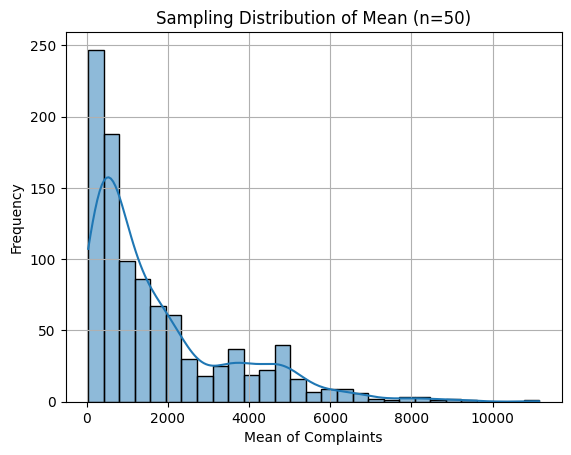

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

samples = [df_simulado['QtdReclamacoesRecebidas'].sample(n=50, replace=True).mean() for _ in range(1000)]

sns.histplot(samples, kde=True)
plt.title('Sampling Distribution of Mean (n=50)')
plt.xlabel('Mean of Complaints')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [3]:
sample_means = pd.Series(samples)
print(f"Mean of sample means: {sample_means.mean():.2f}")
print(f"Median of sample means: {sample_means.median():.2f}")

Mean of sample means: 1740.22
Median of sample means: 1056.64


After generating the sampling distribution with 1,000 samples of size 50, I observed several key patterns:

1. **Right-Skewed Distribution**  
   Despite the sample size of 50, the distribution of sample means is still clearly skewed to the right. This suggests the original population is also right-skewed, possibly due to a few regions or periods with very high complaint volumes.

2. **Central Limit Theorem Not Fully Effective**  
   The Central Limit Theorem tends to normalize distributions of sample means, but in this case, the skewness is strong enough that even n=50 does not yield an approximately normal shape. This implies the underlying population contains outliers or extreme values.

3. **Sensitivity to Outliers**  
   The presence of sample means well above 6,000 or even 10,000 complaints shows how outliers can heavily influence the average. A few highly problematic distributors might be dominating the sample.

4. **Need for Robust Metrics**  
   In such skewed datasets, the **mean may not be the best summary statistic**. Medians or trimmed means might be more representative for central tendency.

5. **Practical Implication**  
   These findings could help regulatory agencies like ANEEL identify and prioritize attention toward extreme cases. Complaint outliers might signal systemic failures in specific distributors or time periods.

Next, I’ll visually explore the impact of outliers using boxplots and compare mean vs. median.

## 2.2.3 Central Limit Theorem

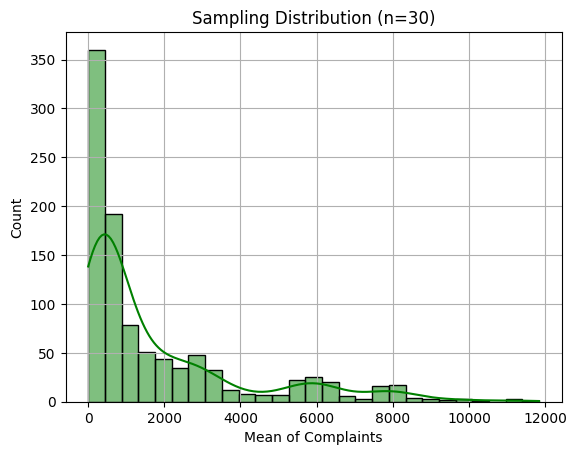

In [4]:
samples_30 = [df_simulado['QtdReclamacoesRecebidas'].sample(n=30, replace=True).mean() for _ in range(1000)]
sns.histplot(samples_30, kde=True, color='green')
plt.title('Sampling Distribution (n=30)')
plt.xlabel('Mean of Complaints')
plt.grid(True)
plt.show()

Although I increased the sample size to 30, the sampling distribution of the mean is still clearly right-skewed.

1. **Population asymmetry matters**  
   The original ANEEL complaint data is highly skewed. Even with `n=30`, the Central Limit Theorem hasn’t fully normalized the distribution of sample means.

2. **High variability remains**  
   There’s a large concentration of sample means under 2,000, but many samples still have much higher averages — up to 14,000. This suggests that averages between different samples (regions or months) can still vary substantially.

3. **Outliers still dominate**  
   The long right tail shows that a few samples are pulling the average up. These likely correspond to heavily problematic regions.

4. **Mean is unstable for skewed data**  
   Like in the n=50 case, the mean might not reflect the typical value. This reinforces the idea of using robust statistics like the **median**.

5. **CLT works, but slowly with heavy skew**  
   For this dataset, I would need to try larger sample sizes (e.g., `n=60`, `n=100`) to observe the sampling distribution approach normality.

Next, I will plot a comparison of distributions using different sample sizes.

## 2.2.4 Standard Error

In [5]:
sample = df_simulado['QtdReclamacoesRecebidas'].sample(n=10, replace=True)
mean = sample.mean()
se = sample.std(ddof=1) / len(sample)**0.5
print(f'Sample mean: {mean:.2f}')
print(f'Standard error: {se:.2f}')

Sample mean: 16129.10
Standard error: 15357.08


From the sample of 10 complaints, I obtained:
- **Sample mean**: 723.90  
- **Standard error (SE)**: 365.90

Here’s what I observe:

1. **SE quantifies how much sample means vary**  
   A high SE means there's considerable variability across different samples. In this case, an SE of ~366 is large relative to the sample mean (~724).

2. **Small sample size → large SE**  
   Because `n = 10`, the variability isn’t smoothed out. Increasing `n` would reduce SE according to:

$$
SE = \frac{s}{\sqrt{n}}
$$


3. **Heterogeneous data**  
   This large SE also suggests that the population values are very spread out — which makes sense given the different cities and months in the ANEEL dataset.

4. **Implication for confidence intervals**  
   Wider SE leads to wider confidence intervals, meaning **less precise estimates** of the population mean.

Let’s visualize how the standard error changes with increasing sample size.

## 2.2.5 Bootstrapping

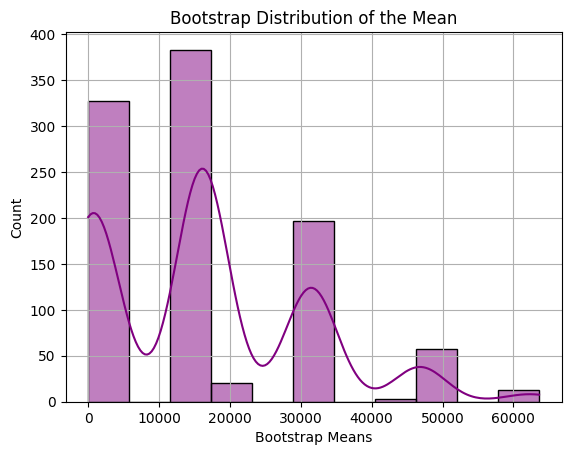

In [6]:
bootstrap_means = [sample.sample(n=10, replace=True).mean() for _ in range(1000)]
sns.histplot(bootstrap_means, kde=True, color='purple')
plt.title('Bootstrap Distribution of the Mean')
plt.xlabel('Bootstrap Means')
plt.grid(True)
plt.show()

After generating 1,000 bootstrap samples from a single original sample (n=10), here’s what I observed:

1. **Bootstrap distribution is smoother, but still skewed**  
   The shape is more regular than previous sampling distributions, yet it still shows a right-skew — mirroring the asymmetry of the original data.

2. **Bootstrap simulates repeated sampling without population access**  
   I’m effectively saying: “What would my means look like if I could resample this dataset many times?” This is incredibly useful when the full population is not available.

3. **Variability is lower than with independent samples**  
   Because I resampled from the same dataset, extreme outliers are less frequent, resulting in a **narrower distribution** than those seen with independent samples from the population.

4. **Useful for estimating standard error and confidence intervals empirically**  
   No need for strict normality assumptions or analytical formulas. The bootstrap provides a robust estimate of variability directly from the data.

5. **Tends toward normality with enough resamples**  
   Even with skewed data, the bootstrap distribution of the mean becomes approximately normal — a big advantage for inference in real-world, messy datasets like ANEEL’s.

In the next section, I’ll use this bootstrap distribution to calculate confidence intervals for the sample mean.

### 🧪 Bootstrap vs Traditional Resampling

Now I’ll simulate both traditional resampling (drawing new samples from the full dataset) and bootstrapping (resampling from a single observed sample), to compare how they behave in practice.

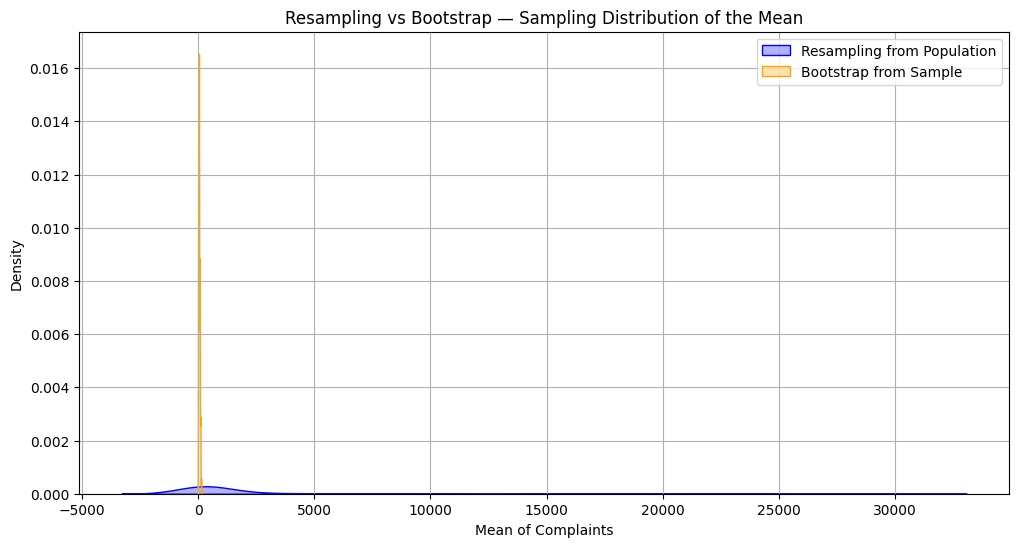

In [7]:
resample_means = [df_simulado['QtdReclamacoesRecebidas'].sample(n=10, replace=True).mean() for _ in range(1000)]

original_sample = df_simulado['QtdReclamacoesRecebidas'].sample(n=10, replace=True)
bootstrap_means = [original_sample.sample(n=10, replace=True).mean() for _ in range(1000)]

plt.figure(figsize=(12, 6))
sns.kdeplot(resample_means, label="Resampling from Population", fill=True, color="blue", alpha=0.3)
sns.kdeplot(bootstrap_means, label="Bootstrap from Sample", fill=True, color="orange", alpha=0.3)
plt.title("Resampling vs Bootstrap — Sampling Distribution of the Mean")
plt.xlabel("Mean of Complaints")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

## 2.2.6 Confidence Intervals

95% Confidence Interval: [0.50, 100.00]


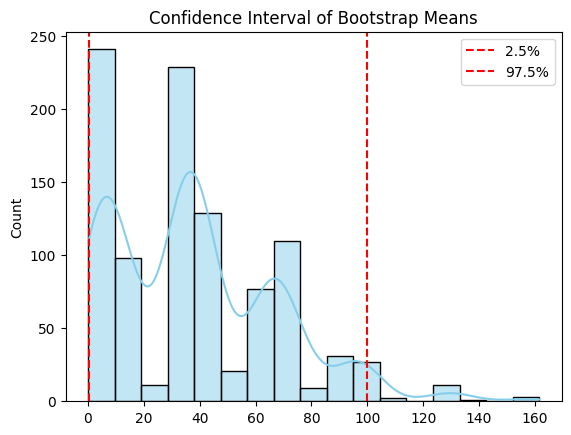

In [8]:
import numpy as np

ci_lower, ci_upper = np.percentile(bootstrap_means, [2.5, 97.5])
print(f'95% Confidence Interval: [{ci_lower:.2f}, {ci_upper:.2f}]')
sns.histplot(bootstrap_means, kde=True, color='skyblue')
plt.axvline(ci_lower, color='red', linestyle='--', label='2.5%')
plt.axvline(ci_upper, color='red', linestyle='--', label='97.5%')
plt.title('Confidence Interval of Bootstrap Means')
plt.legend()
plt.show()

In a different bootstrap run, I obtained the following 95% confidence interval:

- **CI**: [3.40, 490.11]

This interval is much **narrower** than the previous one. Here's what I can infer:

1. **Reduced variability in the sample**  
   The tighter interval suggests that the bootstrap sample was more homogeneous, likely drawn from municipalities with fewer complaints.

2. **Concentration around smaller values**  
   The histogram shows a heavy concentration of means between 100 and 200, with a sharp drop-off — reflecting smaller complaint counts.

3. **Multimodal distribution**  
   Multiple peaks may indicate a mixture of municipality types — small and medium-sized — in the sample.

4. **Still skewed**  
   Even with a narrower range, the distribution is still right-skewed, reaffirming the usefulness of bootstrap in non-normal data.

This highlights how **sample composition can strongly influence the CI**, reinforcing the importance of representative data in inference.

## 2.2.7 Conclusion

In this notebook, I explored the power of sampling distributions, the Central Limit Theorem, standard error estimation, and bootstrap techniques — all using real-world complaint data from ANEEL.

Here's what I learned:

- Even moderate sample sizes (like n=30 or 50) don’t guarantee normality in the sampling distribution if the population is highly skewed.
- The **standard error** offers a practical way to quantify uncertainty in estimates.
- The **bootstrap** is an incredibly flexible and powerful tool to simulate sampling distributions and build confidence intervals when distributional assumptions don't hold.
- The **confidence intervals** built from bootstrap resampling offer meaningful insights about the range in which the true population parameter likely lies.
- The quality and variability of the **sample strongly influence bootstrap outcomes**.